In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

from qiskit import BasicAer
from qiskit.providers.aer import QasmSimulator
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA, SPSA

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

from data_provider import load_titanic_pd
from utils import record_test_result_for_kaggle

In [16]:
df_train, df_test, y, _ = load_titanic_pd('train.csv', 'test.csv')

/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = numer_map[df[col][i]]
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = value
/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:130: SettingWithCopyWarning

     Survived  Pclass Sex Age  SibSp  Parch  Fare Embarked
0           0       3   0   2      1      0     0        0
1           1       1   1   3      1      0     3        1
2           1       3   1   2      0      0     0        0
3           1       1   1   3      1      0     3        0
4           0       3   0   3      0      0     0        0
..        ...     ...  ..  ..    ...    ...   ...      ...
886         0       2   0   2      0      0     1        0
887         1       1   1   1      0      0     3        0
888         0       3   1   3      1      2     2        0
889         1       1   0   2      0      0     3        1
890         0       3   0   3      0      0     0        2

[891 rows x 8 columns]


In [17]:
for col in df_train.columns:
    print(f"{col}: unique {len(df_train[col].unique())}")

Pclass: unique 3
Sex: unique 2
Age: unique 8
SibSp: unique 7
Parch: unique 7
Fare: unique 4
Embarked: unique 4


In [6]:
# Age processing

df_train['Age'] = df_train.Age // 10
df_test['Age'] = df_test.Age // 10

In [7]:
def fare_map(x):
    if x < 10:
        return 0
    if x < 20:
        return 1
    if x < 30:
        return 2
    else:
        return 3
    
df_train['Fare'] = df_train['Fare'].apply(fare_map)
df_test['Fare'] = df_test['Fare'].apply(fare_map)

In [18]:
from quantum_utils import select_features
mvp_col = select_features(df_train, y_train, feat_num=4)

-----
Full features:
Final train score: 0.893378
Final F1 score: 0.855403
-----
Majority
Final train acc: 0.616162
Final train F1:0.000000
Feature rank based on importance
['Sex', 'Age', 'Pclass', 'Fare', 'SibSp', 'Parch', 'Embarked']
Selected features: Sex,Age,Pclass,Fare


In [19]:
df_train, df_test = df_train[mvp_col], df_test[mvp_col]

In [20]:
from sklearn import preprocessing

df_all = pd.concat([df_train, df_test])
# Encode to number
for col in df_train.columns:
    le = preprocessing.LabelEncoder().fit(df_all[col])
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

In [21]:
# b1b2b3 --> (theta, varphi)
def convert_to_angle(b_st):
    if b_st[0] == '1':
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == '1' and b_st[2] == '1':
        varphi = np.pi / 4

    if b_st[1] == '1' and b_st[2] == '0':
        varphi = 3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '0':
        varphi = -3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '1':
        varphi = -np.pi / 4
            
    return [theta, varphi]

data_train = []
data_test = []

bit_each_col = []

# Check number of different category in df_all
for col in df_all.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_all[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_train.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_train.append(var_list)
    
# Encode Test
for row in df_test.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_test.append(var_list)

# data = np.concatenate(data, axis=1)
data_train = np.array(data_train)
data_test = np.array(data_test)

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


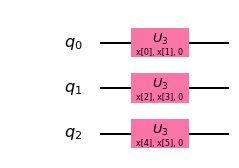

In [22]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data_train.shape[1])]

var_form = variational_forms.RYRZ(num_qubit, depth=4)

qc = QuantumCircuit(num_qubit)

for i in range(num_qubit):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc 
feature_map.draw('mpl')

In [26]:
np.mean(y)

0.3838383838383838

In [33]:
from sklearn.model_selection import KFold

np.random.seed(123123)

kf = KFold(5, shuffle=True)

loss_logs_31 = []
results_31 = []
acc_f1s_train_31 = []
acc_f1s_test_31 = []

def one_and_1_3(x):
    return np.concatenate([x, x[:len(x)//3]], axis=0)

def train_ordinal_quantum(ro=0):
    seed = 10598

    vqc_ordinal_log = []
    def loss_history_callback(_, __, loss, ___):
        vqc_ordinal_log.append(loss)

    qsvm = VQC(SPSA(200), feature_map, var_form, training_input, callback=loss_history_callback)

    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)
    
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


    result = qsvm.run(quantum_instance)
    
    y_pred = qsvm.predict(df_test_q)[1]
    y_pred_train = qsvm.predict(df_train_q)[1]


    # F1 score
    acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))
    acc_f1_test = (np.mean(y_pred == y_test), f1_score(y_test, y_pred))
    
    
    qsvm.save_model(f'models/titanic_QRAC_fold_{ro}')
    
    return vqc_ordinal_log, result, acc_f1_train, acc_f1_test

for idx, (train_idxs, test_idxs) in enumerate(kf.split(df_train)):
    
    
    df_train_q, y_train = data_train[train_idxs], y[train_idxs]
    df_test_q, y_test = data_train[test_idxs], y[test_idxs]
    
    training_input = {
        0: df_train_q[y_train == 0],
        1: one_and_1_3(df_train_q[y_train == 1])
    }

    test_input = {
        0: df_test_q[y_test == 0],
        1: df_test_q[y_test == 1]
    }
    
    loss_log, result, acc_f1_train, acc_f1_test = train_ordinal_quantum(idx)
    loss_logs_31.append(loss_log)
    results_31.append(result)
    acc_f1s_train_31.append(acc_f1_train)
    acc_f1s_test_31.append(acc_f1_test)

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
2020-07-29 20:08:13,189:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimizatio

2020-07-29 20:11:22,876:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:11:26,026:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7506439285287106
2020-07-29 20:11:31,615:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:11:34,421:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7634878303454911
2020-07-29 20:11:40,146:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:11:43,343:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7070794866402286
2020-07-29 20:11:48,996:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:11:51,842:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.698366760183536
2020-07-29 20:11:57,642:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validati

2020-07-29 20:16:04,311:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 1: 0.8670789
2020-07-29 20:16:10,261:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:16:13,103:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6922309778503686
2020-07-29 20:16:19,053:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:16:22,298:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6801840043593301
2020-07-29 20:16:22,299:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 2: 0.6922310
2020-07-29 20:16:22,299:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 2: 0.6801840
2020-07-29 20:16:28,254:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:16:31,076:qiskit.aqua.algorithms.classifiers

2020-07-29 20:19:36,994:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5448556303689489
2020-07-29 20:19:36,994:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 13: 0.5399190
2020-07-29 20:19:36,995:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 13: 0.5448556
2020-07-29 20:19:43,153:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:19:46,041:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5490548991929767
2020-07-29 20:19:51,934:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:19:55,077:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5354285160042799
2020-07-29 20:19:55,078:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 14: 0.5490549
2020-07-29 20:19:55,079:qiskit.aqua.components.optimizer

2020-07-29 20:23:02,759:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5333329360008562
2020-07-29 20:23:08,614:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:23:11,804:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5257973659798746
2020-07-29 20:23:11,805:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 25: 0.5333329
2020-07-29 20:23:11,806:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 25: 0.5257974
2020-07-29 20:23:17,602:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:23:20,730:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5322091271843027
2020-07-29 20:23:26,540:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:23:29,436:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 20:26:27,938:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 36: 0.5265407
2020-07-29 20:26:33,897:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:26:37,039:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5218058740315783
2020-07-29 20:26:42,919:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:26:45,837:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5225301075851386
2020-07-29 20:26:45,838:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 37: 0.5218059
2020-07-29 20:26:45,839:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 37: 0.5225301
2020-07-29 20:26:51,582:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:26:54,715:qiskit.aqua.algorithms.classifi

2020-07-29 20:31:32,366:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5204308
2020-07-29 20:31:32,367:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 53: 0.5170059
2020-07-29 20:31:38,269:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:31:41,377:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5163665681987082
2020-07-29 20:31:47,074:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:31:50,230:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5199235903256361
2020-07-29 20:31:50,231:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 54: 0.5163666
2020-07-29 20:31:50,231:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 54: 0.5199236
2020-07-29 20:31:55,919:qiskit.aqua.utils.run_

2020-07-29 20:35:04,274:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:35:07,094:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5255638667393806
2020-07-29 20:35:07,095:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 65: 0.5246888
2020-07-29 20:35:07,096:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 65: 0.5255639
2020-07-29 20:35:12,946:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:35:16,179:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5214937836580172
2020-07-29 20:35:21,799:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:35:24,838:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5203000798074917
2020-07-29 20:35:24,839:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 20:38:30,487:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:38:33,599:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5160606958779762
2020-07-29 20:38:39,510:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:38:42,765:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5157839579489177
2020-07-29 20:38:42,766:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 77: 0.5160607
2020-07-29 20:38:42,767:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 77: 0.5157840
2020-07-29 20:38:48,511:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:38:51,390:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5146362045671292
2020-07-29 20:38:57,645:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-07-29 20:41:58,984:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5193789
2020-07-29 20:41:58,985:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 88: 0.5164540
2020-07-29 20:42:04,875:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:42:07,999:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5160506258216856
2020-07-29 20:42:13,704:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:42:16,909:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5172961395081365
2020-07-29 20:42:16,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 89: 0.5160506
2020-07-29 20:42:16,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 89: 0.5172961
2020-07-29 20:42:22,782:qiskit.aqua.utils.run_

2020-07-29 20:45:30,983:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:45:33,789:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5144335705693438
2020-07-29 20:45:33,790:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 100: 0.5162571
2020-07-29 20:45:33,790:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 100: 0.5144336
2020-07-29 20:45:39,687:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:45:42,779:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5124397550989777
2020-07-29 20:45:48,628:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:45:51,785:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5122258864564059
2020-07-29 20:45:51,786:qiskit.aqua.components.optimizers.spsa:

2020-07-29 20:48:56,362:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:48:59,470:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5133741852487193
2020-07-29 20:49:05,079:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:49:08,308:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5131801968386637
2020-07-29 20:49:08,309:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 112: 0.5133742
2020-07-29 20:49:08,310:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 112: 0.5131802
2020-07-29 20:49:14,227:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:49:17,044:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5174556402739342
2020-07-29 20:49:23,215:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 20:52:24,880:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5121227
2020-07-29 20:52:24,880:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 123: 0.5132265
2020-07-29 20:52:30,738:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:52:33,879:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5128793737863652
2020-07-29 20:52:39,592:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:52:42,740:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5080537144322781
2020-07-29 20:52:42,740:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 124: 0.5128794
2020-07-29 20:52:42,741:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 124: 0.5080537
2020-07-29 20:52:48,531:qiskit.aqua.utils.

2020-07-29 20:55:56,732:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:55:59,618:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5147386182229694
2020-07-29 20:55:59,619:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 135: 0.5141956
2020-07-29 20:55:59,620:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 135: 0.5147386
2020-07-29 20:56:05,682:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:56:08,847:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5145315879860689
2020-07-29 20:56:14,531:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:56:17,663:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5139471421987012
2020-07-29 20:56:17,664:qiskit.aqua.components.optimizers.spsa:

2020-07-29 20:59:22,614:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:59:25,760:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5095057737688892
2020-07-29 20:59:31,436:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:59:34,595:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5124317844755284
2020-07-29 20:59:34,596:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 147: 0.5095058
2020-07-29 20:59:34,597:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 147: 0.5124318
2020-07-29 20:59:40,411:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:59:43,199:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5094994352485278
2020-07-29 20:59:49,351:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 21:02:50,833:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5134799
2020-07-29 21:02:50,834:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 158: 0.5113312
2020-07-29 21:02:56,790:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:02:59,965:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5080877567739848
2020-07-29 21:03:05,713:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:03:08,841:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5111246154289939
2020-07-29 21:03:08,841:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 159: 0.5080878
2020-07-29 21:03:08,842:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 159: 0.5111246
2020-07-29 21:03:14,890:qiskit.aqua.utils.

2020-07-29 21:06:23,407:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:06:26,251:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5089807163645395
2020-07-29 21:06:26,252:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 170: 0.5135338
2020-07-29 21:06:26,252:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 170: 0.5089807
2020-07-29 21:06:31,995:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:06:35,092:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5089495544695959
2020-07-29 21:06:40,868:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:06:44,031:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5111014423819672
2020-07-29 21:06:44,032:qiskit.aqua.components.optimizers.spsa:

2020-07-29 21:09:48,401:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:09:51,588:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5124708687764216
2020-07-29 21:09:57,517:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:10:00,327:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5140076719706175
2020-07-29 21:10:00,327:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 182: 0.5124709
2020-07-29 21:10:00,328:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 182: 0.5140077
2020-07-29 21:10:06,309:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:10:09,438:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5099217185204017
2020-07-29 21:10:15,124:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 21:13:17,303:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.5079910
2020-07-29 21:13:17,304:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 193: 0.5086132
2020-07-29 21:13:23,556:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:13:26,419:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5108601872006796
2020-07-29 21:13:32,484:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:13:35,296:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5120809779279811
2020-07-29 21:13:35,297:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 194: 0.5108602
2020-07-29 21:13:35,297:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 194: 0.5120810
2020-07-29 21:13:41,225:qiskit.aqua.utils.

2020-07-29 21:15:24,009:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-07-29 21:15:24,010:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-07-29 21:15:24,011:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-07-29 21:15:30,016:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:15:33,231:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9608104865881432
2020-07-29 21:15:39,128:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:15:42,285:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9614381170240296
2020-07-29 21:15:48,164:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:15:50,980:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.025158331

2020-07-29 21:20:28,139:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9451620788604532
2020-07-29 21:20:34,032:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:20:37,283:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9907461177635056
2020-07-29 21:20:43,304:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:20:46,109:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9491027979205748
2020-07-29 21:20:52,320:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:20:55,237:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9249914043033617
2020-07-29 21:21:00,995:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:21:04,143:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-07-29 21:24:44,854:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:24:47,679:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6617303555458851
2020-07-29 21:24:54,095:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:24:56,917:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6452355042962692
2020-07-29 21:24:56,918:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6617304
2020-07-29 21:24:56,919:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.6452355
2020-07-29 21:25:02,830:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:25:06,029:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6699323392823935
2020-07-29 21:25:11,840:qiskit.aqua.utils.run_circuits:INFO: Can't 

2020-07-29 21:28:14,203:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.5860239
2020-07-29 21:28:14,204:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.6053478
2020-07-29 21:28:20,578:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:28:23,412:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5908989791204687
2020-07-29 21:28:29,568:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:28:32,423:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5980888561435722
2020-07-29 21:28:32,424:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.5908990
2020-07-29 21:28:32,425:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 18: 0.5980889
2020-07-29 21:28:38,513:qiskit.aqua.utils.run_

2020-07-29 21:31:46,429:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:31:49,204:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5718161679043925
2020-07-29 21:31:49,205:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5839260
2020-07-29 21:31:49,205:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.5718162
2020-07-29 21:31:54,950:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:31:57,721:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.568811021872942
2020-07-29 21:32:03,872:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:32:06,687:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5746698487016051
2020-07-29 21:32:06,688:qiskit.aqua.components.optimizers.spsa:DEB

2020-07-29 21:35:11,393:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:35:14,564:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5584374510786136
2020-07-29 21:35:20,193:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:35:23,376:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5594500305794405
2020-07-29 21:35:23,377:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.5584375
2020-07-29 21:35:23,377:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.5594500
2020-07-29 21:35:29,337:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:35:32,164:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5594402584523023
2020-07-29 21:35:37,898:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-07-29 21:38:36,109:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.5592868
2020-07-29 21:38:36,110:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.5398296
2020-07-29 21:38:41,748:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:38:44,536:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5476895269635615
2020-07-29 21:38:50,474:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:38:53,612:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5399373894482224
2020-07-29 21:38:53,613:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5476895
2020-07-29 21:38:53,613:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 53: 0.5399374
2020-07-29 21:38:59,358:qiskit.aqua.utils.run_

2020-07-29 21:42:07,409:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:42:10,253:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5406431630027752
2020-07-29 21:42:10,254:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.5386888
2020-07-29 21:42:10,255:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 64: 0.5406432
2020-07-29 21:42:16,760:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:42:19,535:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5390225874360305
2020-07-29 21:42:25,422:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:42:28,558:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5443890741052185
2020-07-29 21:42:28,559:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 21:45:34,914:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:45:37,798:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5458022036567111
2020-07-29 21:45:43,497:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:45:46,620:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5385948158148457
2020-07-29 21:45:46,621:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.5458022
2020-07-29 21:45:46,621:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.5385948
2020-07-29 21:45:52,339:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:45:55,558:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.538504241851487
2020-07-29 21:46:01,434:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-07-29 21:49:04,575:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.5397591
2020-07-29 21:49:04,575:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.5409748
2020-07-29 21:49:10,421:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:49:13,232:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5335266771815277
2020-07-29 21:49:19,270:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:49:22,506:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5399783270514599
2020-07-29 21:49:22,506:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5335267
2020-07-29 21:49:22,507:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 88: 0.5399783
2020-07-29 21:49:28,586:qiskit.aqua.utils.run_

2020-07-29 21:52:35,661:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:52:38,793:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5330905300360016
2020-07-29 21:52:38,794:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 99: 0.5363119
2020-07-29 21:52:38,794:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 99: 0.5330905
2020-07-29 21:52:44,594:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:52:47,764:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5308793454623981
2020-07-29 21:52:53,398:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:52:56,221:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5362915891192217
2020-07-29 21:52:56,222:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 21:56:00,095:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:56:03,217:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5353687154777976
2020-07-29 21:56:08,953:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:56:11,813:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5336356689454377
2020-07-29 21:56:11,813:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.5353687
2020-07-29 21:56:11,814:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.5336357
2020-07-29 21:56:18,195:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:56:21,055:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5347509063647977
2020-07-29 21:56:27,160:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 21:59:29,797:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 122: 0.5345715
2020-07-29 21:59:29,797:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 122: 0.5333825
2020-07-29 21:59:35,463:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:59:38,618:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5347804814332202
2020-07-29 21:59:44,359:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:59:47,220:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5340978130848986
2020-07-29 21:59:47,221:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5347805
2020-07-29 21:59:47,221:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 123: 0.5340978
2020-07-29 21:59:53,391:qiskit.aqua.utils.

2020-07-29 22:03:01,416:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:03:04,616:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5313457871556689
2020-07-29 22:03:04,617:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 134: 0.5291370
2020-07-29 22:03:04,618:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 134: 0.5313458
2020-07-29 22:03:10,629:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:03:13,478:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5341717591757371
2020-07-29 22:03:19,610:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:03:22,761:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.529132143733464
2020-07-29 22:03:22,762:qiskit.aqua.components.optimizers.spsa:D

2020-07-29 22:06:28,013:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:06:30,802:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5303056729617152
2020-07-29 22:06:36,592:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:06:39,766:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5284501156975595
2020-07-29 22:06:39,766:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.5303057
2020-07-29 22:06:39,767:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.5284501
2020-07-29 22:06:45,582:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:06:48,748:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5280647627659932
2020-07-29 22:06:54,666:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 22:09:57,686:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 157: 0.5322920
2020-07-29 22:09:57,686:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: 0.5282985
2020-07-29 22:10:03,581:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:10:06,398:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5267431080719456
2020-07-29 22:10:12,406:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:10:15,575:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5314317904449843
2020-07-29 22:10:15,576:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5267431
2020-07-29 22:10:15,577:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 158: 0.5314318
2020-07-29 22:10:21,767:qiskit.aqua.utils.

2020-07-29 22:13:30,045:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:13:32,880:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5282616721109817
2020-07-29 22:13:32,881:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 169: 0.5304723
2020-07-29 22:13:32,881:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 169: 0.5282617
2020-07-29 22:13:39,140:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:13:42,040:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5274289005370632
2020-07-29 22:13:48,033:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:13:50,946:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5279844596748324
2020-07-29 22:13:50,947:qiskit.aqua.components.optimizers.spsa:

2020-07-29 22:16:56,440:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:16:59,619:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5266690210297786
2020-07-29 22:17:05,315:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:17:08,192:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5280533866567372
2020-07-29 22:17:08,193:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.5266690
2020-07-29 22:17:08,193:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.5280534
2020-07-29 22:17:14,273:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:17:17,412:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5269136952666497
2020-07-29 22:17:23,435:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 22:20:25,471:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: 0.5272329
2020-07-29 22:20:25,472:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 192: 0.5246226
2020-07-29 22:20:31,890:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:20:34,715:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.526051173797041
2020-07-29 22:20:40,889:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:20:43,737:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5294853442917271
2020-07-29 22:20:43,738:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.5260512
2020-07-29 22:20:43,739:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 193: 0.5294853
2020-07-29 22:20:50,045:qiskit.aqua.utils.r

2020-07-29 22:22:50,074:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-07-29 22:22:50,074:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-07-29 22:22:50,075:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-07-29 22:22:50,075:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-07-29 22:22:55,943:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:22:59,089:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9016290017365657
2020-07-29 22:23:05,139:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:23:08,003:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8598618394062081
2020-07-29 22:23:14,090:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation

2020-07-29 22:27:50,250:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:27:53,389:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9252039588863793
2020-07-29 22:27:59,163:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:28:02,281:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8999102244169512
2020-07-29 22:28:08,220:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:28:11,034:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8650840055074849
2020-07-29 22:28:17,144:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:28:19,904:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8589922769941774
2020-07-29 22:28:25,744:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validat

2020-07-29 22:32:03,009:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5: 0.6998734
2020-07-29 22:32:09,232:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:32:12,072:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6814053007253875
2020-07-29 22:32:18,223:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:32:21,050:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7067516720010688
2020-07-29 22:32:21,051:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6814053
2020-07-29 22:32:21,052:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.7067517
2020-07-29 22:32:26,919:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:32:30,032:qiskit.aqua.algorithms.classifiers

2020-07-29 22:35:37,455:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6255163564895236
2020-07-29 22:35:37,456:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.6777034
2020-07-29 22:35:37,457:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.6255164
2020-07-29 22:35:43,295:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:35:46,198:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6268193819341603
2020-07-29 22:35:52,512:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:35:55,363:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6554674650428985
2020-07-29 22:35:55,363:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.6268194
2020-07-29 22:35:55,364:qiskit.aqua.components.optimizer

2020-07-29 22:39:03,131:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5799366895862128
2020-07-29 22:39:09,088:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:39:11,910:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5706495666075853
2020-07-29 22:39:11,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5799367
2020-07-29 22:39:11,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.5706496
2020-07-29 22:39:18,091:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:39:20,935:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5639332690610039
2020-07-29 22:39:27,150:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:39:29,955:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 22:42:29,895:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 40: 0.5428874
2020-07-29 22:42:35,773:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:42:38,973:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5385560057407146
2020-07-29 22:42:44,927:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:42:47,815:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5557269939922832
2020-07-29 22:42:47,816:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.5385560
2020-07-29 22:42:47,817:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.5557270
2020-07-29 22:42:54,144:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:42:57,033:qiskit.aqua.algorithms.classifi

2020-07-29 22:46:05,275:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5311986929681203
2020-07-29 22:46:05,276:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.5291500
2020-07-29 22:46:05,276:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.5311987
2020-07-29 22:46:11,609:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:46:14,430:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5208226548899513
2020-07-29 22:46:20,393:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:46:23,536:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5420006274936443
2020-07-29 22:46:23,537:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5208227
2020-07-29 22:46:23,538:qiskit.aqua.components.optimizer

2020-07-29 22:49:30,506:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5130105924999712
2020-07-29 22:49:36,240:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:49:39,425:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5144763195571033
2020-07-29 22:49:39,426:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.5130106
2020-07-29 22:49:39,427:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 64: 0.5144763
2020-07-29 22:49:45,238:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:49:48,368:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5128339896964202
2020-07-29 22:49:54,073:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:49:56,880:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 22:52:56,005:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 75: 0.5094827
2020-07-29 22:53:01,859:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:53:04,700:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5107497288239143
2020-07-29 22:53:11,002:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:53:13,832:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5055459622457191
2020-07-29 22:53:13,833:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.5107497
2020-07-29 22:53:13,833:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.5055460
2020-07-29 22:53:19,736:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:53:22,878:qiskit.aqua.algorithms.classifi

2020-07-29 22:56:31,388:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5051593128165157
2020-07-29 22:56:31,389:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.5105913
2020-07-29 22:56:31,390:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.5051593
2020-07-29 22:56:37,078:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:56:39,889:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5103312081310462
2020-07-29 22:56:46,229:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:56:49,061:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5060469415662326
2020-07-29 22:56:49,062:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5103312
2020-07-29 22:56:49,062:qiskit.aqua.components.optimizer

2020-07-29 22:59:56,955:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.507017700207499
2020-07-29 23:00:03,113:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:00:05,954:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5050010155644562
2020-07-29 23:00:05,955:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 99: 0.5070177
2020-07-29 23:00:05,956:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 99: 0.5050010
2020-07-29 23:00:11,922:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:00:15,074:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5041993870431162
2020-07-29 23:00:20,788:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:00:23,648:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-07-29 23:03:22,717:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 110: 0.5003446
2020-07-29 23:03:28,488:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:03:31,625:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.503942383414438
2020-07-29 23:03:37,173:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:03:40,283:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5001445016106825
2020-07-29 23:03:40,284:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.5039424
2020-07-29 23:03:40,285:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.5001445
2020-07-29 23:03:46,137:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:03:48,926:qiskit.aqua.algorithms.classi

2020-07-29 23:06:56,952:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5063174884163905
2020-07-29 23:06:56,952:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 122: 0.5003100
2020-07-29 23:06:56,953:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 122: 0.5063175
2020-07-29 23:07:03,178:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:07:05,993:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5034290033900064
2020-07-29 23:07:11,863:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:07:15,062:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5014429367678791
2020-07-29 23:07:15,063:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5034290
2020-07-29 23:07:15,063:qiskit.aqua.components.optimi

2020-07-29 23:10:23,392:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4999040396775824
2020-07-29 23:10:29,134:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:10:32,232:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4981626889895611
2020-07-29 23:10:32,233:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 134: 0.4999040
2020-07-29 23:10:32,233:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 134: 0.4981627
2020-07-29 23:10:38,063:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:10:40,879:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5008571772573003
2020-07-29 23:10:47,134:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:10:49,945:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 23:13:49,579:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 145: 0.4983877
2020-07-29 23:13:55,495:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:13:58,301:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5016915255265034
2020-07-29 23:14:04,432:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:14:07,235:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5049087537149984
2020-07-29 23:14:07,236:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.5016915
2020-07-29 23:14:07,236:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.5049088
2020-07-29 23:14:13,338:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:14:16,191:qiskit.aqua.algorithms.class

2020-07-29 23:17:22,550:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5006084150910906
2020-07-29 23:17:22,551:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 157: 0.4978678
2020-07-29 23:17:22,552:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: 0.5006084
2020-07-29 23:17:28,541:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:17:31,354:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5027807511997987
2020-07-29 23:17:37,334:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:17:40,504:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4999979813112152
2020-07-29 23:17:40,505:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5027808
2020-07-29 23:17:40,506:qiskit.aqua.components.optimi

2020-07-29 23:20:48,768:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4972288717617881
2020-07-29 23:20:54,401:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:20:57,506:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4967692809001689
2020-07-29 23:20:57,507:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 169: 0.4972289
2020-07-29 23:20:57,507:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 169: 0.4967693
2020-07-29 23:21:03,381:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:21:06,498:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5036288827497867
2020-07-29 23:21:12,320:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:21:15,117:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 23:24:13,406:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 180: 0.5010864
2020-07-29 23:24:19,288:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:24:22,395:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49797808623457634
2020-07-29 23:24:28,261:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:24:31,055:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4965893858777975
2020-07-29 23:24:31,056:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.4979781
2020-07-29 23:24:31,057:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.4965894
2020-07-29 23:24:37,163:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:24:40,345:qiskit.aqua.algorithms.clas

2020-07-29 23:27:47,186:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5020220162185901
2020-07-29 23:27:47,187:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: 0.4962681
2020-07-29 23:27:47,187:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 192: 0.5020220
2020-07-29 23:27:53,065:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:27:56,252:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4967687127687267
2020-07-29 23:28:02,137:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:28:05,007:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4965094828416956
2020-07-29 23:28:05,008:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.4967687
2020-07-29 23:28:05,009:qiskit.aqua.components.optimi

2020-07-29 23:30:11,612:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-07-29 23:30:11,612:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-07-29 23:30:11,613:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-07-29 23:30:11,614:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-07-29 23:30:17,476:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:30:20,317:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7869454847620436
2020-07-29 23:30:26,241:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:30:29,424:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.822700098218663
2020-07-29 23:30:35,569:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation 

2020-07-29 23:35:11,821:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:35:14,743:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8633686846045504
2020-07-29 23:35:21,080:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:35:23,974:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7945669958360198
2020-07-29 23:35:30,055:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:35:32,940:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7860118317597334
2020-07-29 23:35:39,065:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:35:41,988:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.846487864186816
2020-07-29 23:35:47,845:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validati

2020-07-29 23:39:26,547:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5: 0.6608656
2020-07-29 23:39:32,661:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:39:35,841:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6191723596946601
2020-07-29 23:39:41,584:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:39:44,407:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6529673782717156
2020-07-29 23:39:44,408:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6191724
2020-07-29 23:39:44,408:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.6529674
2020-07-29 23:39:50,408:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:39:53,247:qiskit.aqua.algorithms.classifiers

2020-07-29 23:43:02,679:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6023041840449501
2020-07-29 23:43:02,680:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.6168395
2020-07-29 23:43:02,681:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.6023042
2020-07-29 23:43:08,464:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:43:11,667:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6173635323172774
2020-07-29 23:43:17,644:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:43:20,573:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.59585173377385
2020-07-29 23:43:20,574:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.6173635
2020-07-29 23:43:20,575:qiskit.aqua.components.optimizers.

2020-07-29 23:46:28,898:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5811878210828769
2020-07-29 23:46:35,021:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:46:37,850:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5545966210891671
2020-07-29 23:46:37,851:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5811878
2020-07-29 23:46:37,851:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.5545966
2020-07-29 23:46:44,078:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:46:46,912:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.579132623988731
2020-07-29 23:46:52,924:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:46:56,095:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-07-29 23:49:56,749:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 40: 0.5388902
2020-07-29 23:50:02,457:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:50:05,518:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5368141619414054
2020-07-29 23:50:11,058:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:50:14,088:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5435396459313312
2020-07-29 23:50:14,088:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.5368142
2020-07-29 23:50:14,089:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.5435396
2020-07-29 23:50:20,046:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:50:22,836:qiskit.aqua.algorithms.classifi

2020-07-29 23:53:31,129:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5238036303987716
2020-07-29 23:53:31,130:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.5379733
2020-07-29 23:53:31,130:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.5238036
2020-07-29 23:53:36,859:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:53:40,093:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5311991135387027
2020-07-29 23:53:46,040:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:53:48,788:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5302421134572937
2020-07-29 23:53:48,790:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5311991
2020-07-29 23:53:48,790:qiskit.aqua.components.optimizer

2020-07-29 23:56:59,143:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5251397269761443
2020-07-29 23:57:05,219:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:57:08,062:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5294384772405141
2020-07-29 23:57:08,063:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.5251397
2020-07-29 23:57:08,064:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 64: 0.5294385
2020-07-29 23:57:14,285:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:57:17,100:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5237017120449721
2020-07-29 23:57:23,028:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:57:26,139:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-30 00:00:26,686:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 75: 0.5232533
2020-07-30 00:00:32,487:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:00:35,655:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5242747395277458
2020-07-30 00:00:41,497:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:00:44,735:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5224107795423102
2020-07-30 00:00:44,736:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.5242747
2020-07-30 00:00:44,737:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.5224108
2020-07-30 00:00:50,602:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:00:53,459:qiskit.aqua.algorithms.classifi

2020-07-30 00:04:03,550:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5266892419362635
2020-07-30 00:04:03,551:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.5190737
2020-07-30 00:04:03,552:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.5266892
2020-07-30 00:04:09,721:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:04:12,594:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5203127256306811
2020-07-30 00:04:19,041:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:04:21,920:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.522783812587711
2020-07-30 00:04:21,920:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5203127
2020-07-30 00:04:21,921:qiskit.aqua.components.optimizers

2020-07-30 00:07:30,755:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5217688272423996
2020-07-30 00:07:36,707:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:07:39,573:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5214470666239613
2020-07-30 00:07:39,574:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 99: 0.5217688
2020-07-30 00:07:39,575:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 99: 0.5214471
2020-07-30 00:07:45,916:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:07:48,756:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.520314686757194
2020-07-30 00:07:54,681:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:07:57,809:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-07-30 00:10:58,973:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 110: 0.5230661
2020-07-30 00:11:04,887:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:11:07,999:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5202482958764962
2020-07-30 00:11:13,881:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:11:16,772:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5185094780627
2020-07-30 00:11:16,773:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.5202483
2020-07-30 00:11:16,774:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.5185095
2020-07-30 00:11:22,943:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:11:25,778:qiskit.aqua.algorithms.classifi

2020-07-30 00:14:33,032:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5153149142045914
2020-07-30 00:14:33,034:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 122: 0.5188236
2020-07-30 00:14:33,036:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 122: 0.5153149
2020-07-30 00:14:39,517:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:14:42,260:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5163486788755144
2020-07-30 00:14:48,288:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:14:51,348:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5190033627979204
2020-07-30 00:14:51,349:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5163487
2020-07-30 00:14:51,350:qiskit.aqua.components.optimi

2020-07-30 00:18:00,762:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5175277175107366
2020-07-30 00:18:06,720:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:18:09,851:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5161050769966448
2020-07-30 00:18:09,852:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 134: 0.5175277
2020-07-30 00:18:09,853:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 134: 0.5161051
2020-07-30 00:18:15,763:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:18:18,668:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5190943239936675
2020-07-30 00:18:24,913:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:18:27,743:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-30 00:21:27,644:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 145: 0.5171974
2020-07-30 00:21:33,426:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:21:36,270:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5187776668906007
2020-07-30 00:21:42,455:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:21:45,276:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5202724889966944
2020-07-30 00:21:45,277:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.5187777
2020-07-30 00:21:45,278:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.5202725
2020-07-30 00:21:51,062:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:21:54,195:qiskit.aqua.algorithms.class

2020-07-30 00:25:00,970:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5161931280779746
2020-07-30 00:25:00,970:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 157: 0.5175935
2020-07-30 00:25:00,971:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: 0.5161931
2020-07-30 00:25:07,399:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:25:10,137:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.516412714188202
2020-07-30 00:25:15,878:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:25:19,014:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5165747495457416
2020-07-30 00:25:19,015:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5164127
2020-07-30 00:25:19,015:qiskit.aqua.components.optimiz

2020-07-30 00:28:28,433:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5154058647408695
2020-07-30 00:28:34,120:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:28:36,990:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5167206368264651
2020-07-30 00:28:36,991:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 169: 0.5154059
2020-07-30 00:28:36,992:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 169: 0.5167206
2020-07-30 00:28:43,416:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:28:46,287:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5151545480757227
2020-07-30 00:28:52,333:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:28:55,486:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-30 00:31:54,115:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 180: 0.5153412
2020-07-30 00:32:00,271:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:32:03,104:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5129597712247064
2020-07-30 00:32:09,281:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:32:12,178:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5146351060759197
2020-07-30 00:32:12,179:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.5129598
2020-07-30 00:32:12,179:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.5146351
2020-07-30 00:32:18,591:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:32:21,433:qiskit.aqua.algorithms.class

2020-07-30 00:35:30,013:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5183887379286496
2020-07-30 00:35:30,014:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: 0.5177878
2020-07-30 00:35:30,014:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 192: 0.5183887
2020-07-30 00:35:35,851:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:35:39,040:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5195476211515592
2020-07-30 00:35:44,853:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:35:47,991:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5125807866671408
2020-07-30 00:35:47,992:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.5195476
2020-07-30 00:35:47,993:qiskit.aqua.components.optimi

2020-07-30 00:37:55,954:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-07-30 00:37:55,955:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-07-30 00:37:55,956:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-07-30 00:37:55,956:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-07-30 00:38:02,137:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:38:05,030:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7352624108438994
2020-07-30 00:38:11,364:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:38:14,199:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7493717932223696
2020-07-30 00:38:20,587:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation

2020-07-30 00:42:58,639:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:43:01,446:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7590102457907897
2020-07-30 00:43:07,639:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:43:10,559:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7502518701539491
2020-07-30 00:43:16,364:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:43:19,580:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7099351730174166
2020-07-30 00:43:25,503:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:43:28,651:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7523740027338033
2020-07-30 00:43:34,532:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validat

2020-07-30 00:47:12,149:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5: 0.6749856
2020-07-30 00:47:18,116:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:47:21,254:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6947523675598059
2020-07-30 00:47:27,272:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:47:30,084:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6704189124116201
2020-07-30 00:47:30,085:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6947524
2020-07-30 00:47:30,086:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.6704189
2020-07-30 00:47:35,871:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:47:39,079:qiskit.aqua.algorithms.classifiers

2020-07-30 00:50:47,734:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.627709037301111
2020-07-30 00:50:47,735:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.5770686
2020-07-30 00:50:47,736:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.6277090
2020-07-30 00:50:53,547:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:50:56,698:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5743979712414357
2020-07-30 00:51:02,461:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:51:05,611:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5607609077194461
2020-07-30 00:51:05,612:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.5743980
2020-07-30 00:51:05,613:qiskit.aqua.components.optimizers

2020-07-30 00:54:15,310:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5561342971516255
2020-07-30 00:54:21,249:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:54:24,270:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5528464574510814
2020-07-30 00:54:24,271:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5561343
2020-07-30 00:54:24,271:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.5528465
2020-07-30 00:54:30,147:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:54:33,269:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5547118495652787
2020-07-30 00:54:39,369:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:54:42,223:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-30 00:57:41,476:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 40: 0.5451165
2020-07-30 00:57:47,498:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:57:50,370:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5438787443740153
2020-07-30 00:57:56,057:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:57:58,935:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5455758050732742
2020-07-30 00:57:58,936:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.5438787
2020-07-30 00:57:58,936:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.5455758
2020-07-30 00:58:05,003:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:58:07,888:qiskit.aqua.algorithms.classifi

2020-07-30 01:01:16,436:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5437427286609727
2020-07-30 01:01:16,437:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.5366913
2020-07-30 01:01:16,438:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.5437427
2020-07-30 01:01:22,233:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:01:25,379:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5351078152753764
2020-07-30 01:01:31,169:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:01:34,047:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5441467557837478
2020-07-30 01:01:34,048:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5351078
2020-07-30 01:01:34,048:qiskit.aqua.components.optimizer

2020-07-30 01:04:43,005:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5301835870227288
2020-07-30 01:04:48,639:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:04:51,797:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5283191820348134
2020-07-30 01:04:51,798:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.5301836
2020-07-30 01:04:51,798:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 64: 0.5283192
2020-07-30 01:04:57,635:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:05:00,533:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5291741455434608
2020-07-30 01:05:06,807:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:05:09,692:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-30 01:08:09,584:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 75: 0.5339364
2020-07-30 01:08:15,739:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:08:18,623:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.527716975566798
2020-07-30 01:08:24,689:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:08:27,577:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5293415856937372
2020-07-30 01:08:27,578:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.5277170
2020-07-30 01:08:27,579:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.5293416
2020-07-30 01:08:33,444:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:08:36,639:qiskit.aqua.algorithms.classifie

2020-07-30 01:11:45,628:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5235090771555853
2020-07-30 01:11:45,629:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.5279499
2020-07-30 01:11:45,630:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.5235091
2020-07-30 01:11:51,610:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:11:54,801:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5224410435870327
2020-07-30 01:12:00,751:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:12:03,996:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5280723514166331
2020-07-30 01:12:03,997:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5224410
2020-07-30 01:12:03,997:qiskit.aqua.components.optimizer

2020-07-30 01:15:12,067:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.524103279683728
2020-07-30 01:15:17,666:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:15:20,800:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5193357868582876
2020-07-30 01:15:20,801:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 99: 0.5241033
2020-07-30 01:15:20,802:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 99: 0.5193358
2020-07-30 01:15:26,719:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:15:29,631:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5226418213367192
2020-07-30 01:15:35,780:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:15:38,655:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-07-30 01:18:38,112:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 110: 0.5198158
2020-07-30 01:18:44,194:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:18:47,078:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5268484317331628
2020-07-30 01:18:53,088:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:18:55,896:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5187251770760831
2020-07-30 01:18:55,897:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.5268484
2020-07-30 01:18:55,898:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.5187252
2020-07-30 01:19:01,632:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:19:04,803:qiskit.aqua.algorithms.class

2020-07-30 01:22:13,068:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5179741403244269
2020-07-30 01:22:13,069:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 122: 0.5215391
2020-07-30 01:22:13,070:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 122: 0.5179741
2020-07-30 01:22:19,064:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:22:21,942:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5192324125686766
2020-07-30 01:22:27,964:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:22:30,847:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.519888203388812
2020-07-30 01:22:30,848:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5192324
2020-07-30 01:22:30,849:qiskit.aqua.components.optimiz

2020-07-30 01:25:39,004:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.517848196905002
2020-07-30 01:25:45,020:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:25:47,868:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5193574230427318
2020-07-30 01:25:47,869:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 134: 0.5178482
2020-07-30 01:25:47,869:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 134: 0.5193574
2020-07-30 01:25:53,738:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:25:56,553:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5154403968835398
2020-07-30 01:26:02,985:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:26:05,818:qiskit.aqua.algorithms.classifiers.vqc:D

2020-07-30 01:29:05,874:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 145: 0.5186728
2020-07-30 01:29:11,870:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:29:14,710:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5152203508630177
2020-07-30 01:29:21,007:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:29:23,842:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5202791691524702
2020-07-30 01:29:23,843:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.5152204
2020-07-30 01:29:23,844:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.5202792
2020-07-30 01:29:29,764:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:29:32,833:qiskit.aqua.algorithms.class

2020-07-30 01:32:41,198:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5181151670040719
2020-07-30 01:32:41,199:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 157: 0.5146774
2020-07-30 01:32:41,200:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: 0.5181152
2020-07-30 01:32:47,282:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:32:50,511:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5174822629396255
2020-07-30 01:32:56,370:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:32:59,253:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5185347322012865
2020-07-30 01:32:59,254:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5174823
2020-07-30 01:32:59,255:qiskit.aqua.components.optimi

2020-07-30 01:36:06,809:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5163162922051356
2020-07-30 01:36:12,894:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:36:16,044:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5165598699514691
2020-07-30 01:36:16,045:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 169: 0.5163163
2020-07-30 01:36:16,045:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 169: 0.5165599
2020-07-30 01:36:21,994:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:36:24,909:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.515511714689329
2020-07-30 01:36:31,014:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:36:33,911:qiskit.aqua.algorithms.classifiers.vqc:D

2020-07-30 01:39:33,653:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 180: 0.5146080
2020-07-30 01:39:39,629:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:39:42,811:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5171835304909805
2020-07-30 01:39:48,659:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:39:51,793:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5165533204898753
2020-07-30 01:39:51,794:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.5171835
2020-07-30 01:39:51,794:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.5165533
2020-07-30 01:39:57,565:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:40:00,422:qiskit.aqua.algorithms.class

2020-07-30 01:43:08,452:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5134828848520642
2020-07-30 01:43:08,453:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: 0.5127717
2020-07-30 01:43:08,453:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 192: 0.5134829
2020-07-30 01:43:14,347:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:43:17,378:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5147286379977157
2020-07-30 01:43:23,148:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:43:26,370:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5132681090319224
2020-07-30 01:43:26,371:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.5147286
2020-07-30 01:43:26,372:qiskit.aqua.components.optimi

In [34]:
import pickle

qrac_record = {
    'loss_logs': loss_logs_31,
    'result': results_31,
    'acc_f1s_train': acc_f1s_train_31,
    'acc_f1s_test': acc_f1s_test_31
}

with open('results/titanic_qrac_record.pk', 'wb') as f:
    pickle.dump(qrac_record, f)

Text(0, 0.5, 'Loss')

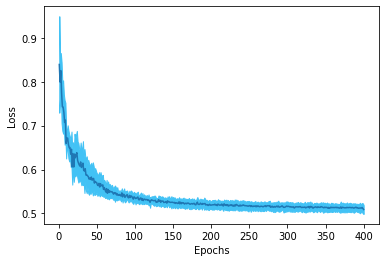

In [61]:
mean_epoch = np.mean(loss_logs_31, axis=0)[-400:]
std_epoch = np.std(loss_logs_31, axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#42c2f5')

plt.xlabel('Epochs')
plt.ylabel('Loss')

In [36]:
np.mean(acc_f1s_train_31, axis=0),np.mean(acc_f1s_test_31, axis=0)

(array([0.77468758, 0.69455358]), array([0.76649928, 0.68347569]))

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  """Entry point for launching an IPython kernel.
2020-07-30 02:36:01,558:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layo

In [47]:
import glob

results = []

for model_name in glob.glob('models/bc_QRAC_fold_*.npz'):
    qsvm = VQC(SPSA(0), feature_map, var_form, training_input)
    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)

    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=0, seed_transpiler=0,optimization_level=3)
    qsvm.run(quantum_instance)
    qsvm.load_model(model_name)
    results.append(qsvm.predict(data_test))

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  
2020-07-30 02:38:01,247:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 0, 'optimization_

2020-07-30 02:38:59,532:qiskit.aqua.components.optimizers.spsa:DEBUG: Final objective function is: 1.1475298
2020-07-30 02:38:59,533:qiskit.aqua.algorithms.classifiers.vqc:INFO: Optimization complete in 26.459423542022705 seconds.
Found opt_params [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] in 3 evals
2020-07-30 02:38:59,535:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-07-30 02:39:02,666:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 02:39:04,204:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pas

2020-07-30 02:40:02,117:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.144336633326457
2020-07-30 02:40:02,117:qiskit.aqua.components.optimizers.spsa:DEBUG: Final objective function is: 1.1443366
2020-07-30 02:40:02,118:qiskit.aqua.algorithms.classifiers.vqc:INFO: Optimization complete in 26.263785362243652 seconds.
Found opt_params [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] in 3 evals
2020-07-30 02:40:02,120:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-07-30 02:40:05,033:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 02:40:06,822:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx'

In [55]:
av_submission = []
majority_vote = []

for result in results:
    pred_av, pred_maj = np.round(results[0][0][:,1]).astype(np.float32), results[0][1].astype(np.float32)
    av_submission.append(pred_av)
    majority_vote.append(pred_maj)
    
av_submission = np.round(np.mean(av_submission, axis=0)).astype(np.int32)
majority_vote = np.round(np.mean(majority_vote, axis=0)).astype(np.int32)

In [58]:
av_submission - majority_vote

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [56]:
majority_vote

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [60]:
def record_test_result_for_kaggle(y_pred, submission_file):
    start = 892
    end = 1309
    result = "PassengerId,Survived\n"
    for i in range(start, end + 1):
        result += "%d,%d\n" % (i, y_pred[i - 892])
    with open(submission_file, "w", encoding="utf-8") as writer:
        writer.write(result)

# prediction = qsvm_encode.predict(data_test)[1]
record_test_result_for_kaggle(av_submission, 'av_submission.csv')

In [36]:
prediction = np.zeros(len(df_test))
record_test_result_for_kaggle(prediction, 'stupid_submission.csv')

In [ ]:
qsvm_encode.save_model('models/Titanic_VQC')

In [26]:
# load model 
# qsvm_encode = VQC(COBYLA(1), feature_map, var_form, training_input)
# backend = BasicAer.get_backend('qasm_simulator')
# quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# qsvm_encode.run(quantum_instance)

qsvm_encode.load_model('models/Titanic_VQC.npz')

In [28]:
prediction = qsvm_encode.predict(data_train)[1]

np.mean(prediction == y_train), f1_score(prediction, y_train)

2020-07-09 00:33:37,543:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


NameError: name 'f1' is not defined

In [33]:
np.mean(prediction == y_train), f1_score(prediction, y_train)

(0.675645342312009, 0.5743740795287187)

# Continuous+mix encoding (VQC + QRAC)

In [2]:
df_train, y_train, df_test = load_titanic_pd('train.csv', 'test.csv')

/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col][i] = numer_map[df[col][i]]
/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col][i] = value
/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:101: SettingWithCopyWarning: 
A value is trying to be set

     Survived  Pclass Sex Age  SibSp  Parch  Fare Embarked
0           0       3   0   2      1      0     0        0
1           1       1   1   3      1      0     3        1
2           1       3   1   2      0      0     0        0
3           1       1   1   3      1      0     3        0
4           0       3   0   3      0      0     0        0
5           0       3   0   3      0      0     0        2
6           0       1   0   5      0      0     3        0
7           0       3   0   0      3      1     2        0
8           1       3   1   2      0      2     1        0
9           1       2   1   1      1      0     3        1
10          1       3   1   0      1      1     1        0
11          1       1   1   5      0      0     2        0
12          0       3   0   2      0      0     0        0
13          0       3   0   3      1      5     3        0
14          0       3   1   1      0      0     0        0
15          1       2   1   5      0      0     1       

In [3]:
df_train['Fare'] = np.log(df_train['Fare'] + 1)
df_test['Fare'] = np.log(df_test['Fare'].astype(np.float32) + 1)

In [23]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,0.05,0,0,0.000000,0
1,3,1,0.0666667,1,0,0.000000,1
2,2,0,0.1,0,0,0.000000,0
3,3,0,0.0333333,0,0,0.000000,1
4,3,1,0.0333333,1,1,0.693147,1


In [22]:
df_test['Fare'].head(10)

0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    0.693147
5    0.000000
6    0.000000
7    1.098612
8    0.000000
9    1.098612
Name: Fare, dtype: float32

In [6]:
df_train['Age'] = df_train['Age'] / 60
df_test['Age'] = df_test['Age'] / 60

In [7]:
cat_col = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
num_col = ['Age', 'Fare']

In [8]:
df_train_cat = df_train[cat_col]
df_test_cat = df_test[cat_col]

df_train_num = df_train[num_col]
df_test_num = df_test[num_col]

In [9]:
# b1b2b3 --> (theta, varphi)
def convert_to_angle(b_st):
    if b_st[0] == '1':
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == '1' and b_st[2] == '1':
        varphi = np.pi / 4

    if b_st[1] == '1' and b_st[2] == '0':
        varphi = 3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '0':
        varphi = -3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '1':
        varphi = -np.pi / 4
            
    return [theta, varphi]

data_train = []
data_test = []

bit_each_col = []

df_all = pd.concat([df_train_cat, df_test_cat])

# Check number of different category in df_all
for col in df_all.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_all[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_train_cat.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_train.append(var_list)
    
# Encode Test
for row in df_test_cat.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_test.append(var_list)

# data = np.concatenate(data, axis=1)
data_train = np.array(data_train)
data_test = np.array(data_test)

In [10]:
data_train_num = df_train_num.values
data_test_num = df_test_num.values

In [11]:
data_train = np.concatenate([data_train, data_train_num], axis=1)
data_test = np.concatenate([data_test, data_test_num], axis=1)

In [12]:
data_train.shape, data_test.shape

((891, 10), (418, 10))

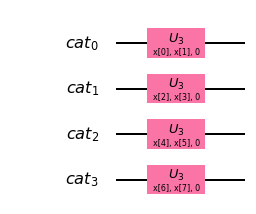

In [13]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter, QuantumRegister
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data_train.shape[1])]

qr = QuantumRegister(num_qubit, 'cat')
qc = QuantumCircuit(qr)

for i in range(num_qubit):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder
# tmp1 = feature_map.assign_parameters(X[:num_qubit])
# tmp2 = feature_map.assign_parameters(X[num_qubit:])

feature_map_cat = qc #+ tmp1 + tmp2 
feature_map_cat.draw('mpl')

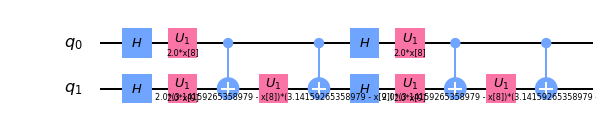

In [14]:
# Continuous circuit

X1 = Parameter('x[8]')
X2 = Parameter('x[9]')

feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear')

feature_map = feature_map.assign_parameters([X1, X2])

feature_map.draw('mpl')

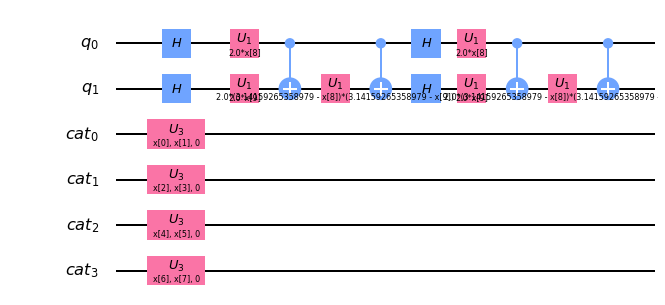

In [15]:
feature_map_all = feature_map.combine(feature_map_cat)
feature_map_all.draw('mpl')

In [16]:
# Make training data

training_input = {
    0: data_train[y_train == 0],
    1: data_train[y_train == 1]
}

In [17]:
# 

seed = 10598

vqc_encode_with_num_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_with_num_log.append(loss)


# feature_map = ZZFeatureMap(feature_dimension=num_qubit, reps=2, entanglement='linear')
var_form = variational_forms.RYRZ(6, depth=4)

qsvm_encode = VQC(SPSA(200), feature_map_all, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  del sys.path[0]
2020-07-10 01:40:17,159:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra

2020-07-10 01:59:44,875:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6978227864943641
2020-07-10 02:00:35,161:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6641369808805189
2020-07-10 02:01:29,489:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7097806113555607
2020-07-10 02:02:21,961:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6479905685211301
2020-07-10 02:02:21,963:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 15 of 25
2020-07-10 02:03:00,663:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6597253254175388
2020-07-10 02:03:38,902:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6866470010219077
2020-07-10 02:04:18,250:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6640004356178763
2020-07-10 02:04:56,606:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6741018

2020-07-10 02:32:14,767:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.662704044552734
2020-07-10 02:32:53,947:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6858486679741306
2020-07-10 02:32:53,949:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 11: 0.6627040
2020-07-10 02:32:53,950:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 11: 0.6858487
2020-07-10 02:33:41,818:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.690136191475854
2020-07-10 02:34:25,082:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6884959610126431
2020-07-10 02:34:25,084:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 12: 0.6901362
2020-07-10 02:34:25,085:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 0.6884960
2020-07-10 02:35:07,824:qiskit.aqua.algorithms.cla

2020-07-10 02:57:18,114:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6037414599688735
2020-07-10 02:57:18,116:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 28: 0.6215160
2020-07-10 02:57:18,117:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 28: 0.6037415
2020-07-10 02:57:53,390:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.598652409977434
2020-07-10 02:58:29,317:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6203714847899428
2020-07-10 02:58:29,320:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5986524
2020-07-10 02:58:29,320:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.6203715
2020-07-10 02:59:05,728:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6071380334062831
2020-07-10 02:59:41,722:qiskit.aqua.algorithms.cl

2020-07-10 03:17:32,313:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 45: 0.5861323
2020-07-10 03:17:32,313:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 45: 0.5593678
2020-07-10 03:18:09,300:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5699069421854679
2020-07-10 03:18:45,429:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5683295455137718
2020-07-10 03:18:45,431:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 46: 0.5699069
2020-07-10 03:18:45,432:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 46: 0.5683295
2020-07-10 03:19:20,167:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5539767280377486
2020-07-10 03:19:57,785:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5732913575904321
2020-07-10 03:19:57,787:qiskit.aqua.components.o

2020-07-10 03:37:42,874:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 62: 0.5241803
2020-07-10 03:38:18,163:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5222037659720453
2020-07-10 03:38:53,464:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5412051569797188
2020-07-10 03:38:53,466:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 63: 0.5222038
2020-07-10 03:38:53,467:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 63: 0.5412052
2020-07-10 03:39:28,441:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5345577958532489
2020-07-10 03:40:04,229:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5155660243138442
2020-07-10 03:40:04,231:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.5345578
2020-07-10 03:40:04,232:qiskit.aqua.components.o

2020-07-10 03:58:32,754:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5188152827385304
2020-07-10 03:59:07,878:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4939710980048807
2020-07-10 03:59:07,881:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 80: 0.5188153
2020-07-10 03:59:07,882:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 80: 0.4939711
2020-07-10 03:59:43,402:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5007676689997459
2020-07-10 04:00:19,085:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4986399900954613
2020-07-10 04:00:19,088:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 81: 0.5007677
2020-07-10 04:00:19,089:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 81: 0.4986400
2020-07-10 04:00:54,317:qiskit.aqua.algorithms.c

2020-07-10 04:19:10,918:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49384996173594764
2020-07-10 04:19:10,921:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 97: 0.4860526
2020-07-10 04:19:10,922:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 97: 0.4938500
2020-07-10 04:19:47,119:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4881715133680305
2020-07-10 04:20:23,110:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4913710299543273
2020-07-10 04:20:23,113:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 98: 0.4881715
2020-07-10 04:20:23,113:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 98: 0.4913710
2020-07-10 04:20:59,060:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4884164469080427
2020-07-10 04:21:33,979:qiskit.aqua.algorithms.

2020-07-10 04:39:17,634:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 114: 0.4846210
2020-07-10 04:39:17,636:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 114: 0.4794160
2020-07-10 04:39:53,570:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4843528813282956
2020-07-10 04:40:28,755:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48606590530747434
2020-07-10 04:40:28,758:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 115: 0.4843529
2020-07-10 04:40:28,759:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 115: 0.4860659
2020-07-10 04:41:04,546:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48317436456200946
2020-07-10 04:41:39,695:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4823931471846053
2020-07-10 04:41:39,698:qiskit.aqua.compon

2020-07-10 04:59:30,414:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 131: 0.4840897
2020-07-10 05:00:07,003:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4832384816247759
2020-07-10 05:00:42,353:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4824674658420433
2020-07-10 05:00:42,356:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 132: 0.4832385
2020-07-10 05:00:42,357:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 132: 0.4824675
2020-07-10 05:01:17,747:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48361449069526463
2020-07-10 05:01:53,215:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4815972476986018
2020-07-10 05:01:53,218:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 133: 0.4836145
2020-07-10 05:01:53,219:qiskit.aqua.compone

2020-07-10 05:20:15,543:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4834343242923306
2020-07-10 05:20:50,897:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47948581849516664
2020-07-10 05:20:50,899:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 149: 0.4834343
2020-07-10 05:20:50,900:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 149: 0.4794858
2020-07-10 05:21:26,171:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48373640511076743
2020-07-10 05:22:01,136:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48375487245934473
2020-07-10 05:22:01,138:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 150: 0.4837364
2020-07-10 05:22:01,139:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 150: 0.4837549
2020-07-10 05:22:36,388:qiskit.aqua.algor

2020-07-10 05:42:57,508:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48048788561384537
2020-07-10 05:42:57,511:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 166: 0.4857042
2020-07-10 05:42:57,513:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 166: 0.4804879
2020-07-10 05:43:38,417:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4787465566052345
2020-07-10 05:44:20,696:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4781982284584361
2020-07-10 05:44:20,699:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 167: 0.4787466
2020-07-10 05:44:20,700:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 167: 0.4781982
2020-07-10 05:44:57,334:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48441597922971863
2020-07-10 05:45:32,374:qiskit.aqua.algori

2020-07-10 06:03:22,448:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 183: 0.4757646
2020-07-10 06:03:22,449:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 183: 0.4791143
2020-07-10 06:03:58,733:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47574946472011714
2020-07-10 06:04:35,842:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47671805440113113
2020-07-10 06:04:35,845:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 184: 0.4757495
2020-07-10 06:04:35,847:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 184: 0.4767181
2020-07-10 06:05:11,701:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4809099666584187
2020-07-10 06:05:46,915:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47864556603867414
2020-07-10 06:05:46,917:qiskit.aqua.compo

In [18]:
def record_test_result_for_kaggle(y_pred, submission_file):
    start = 892
    end = 1309
    result = "PassengerId,Survived\n"
    for i in range(start, end + 1):
        result += "%d,%d\n" % (i, y_pred[i - 892])
    with open(submission_file, "w", encoding="utf-8") as writer:
        writer.write(result)

prediction = qsvm_encode.predict(data_test)[1]
record_test_result_for_kaggle(prediction, 'encode_with_num_submission.csv')

2020-07-10 06:23:04,491:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


In [79]:
# load model 
# qsvm_encode = VQC(COBYLA(1), feature_map, var_form, training_input)
# backend = BasicAer.get_backend('qasm_simulator')
# quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# qsvm_encode.run(quantum_instance)

qsvm_encode.load_model('models/Titanic_VQC_withnum_SPSA.npz')

In [83]:
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
qsvm_encode.run(quantum_instance)

2020-07-10 01:30:30,638:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-10 01:30:30,641:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.14159

KeyboardInterrupt: 

In [21]:
prediction = qsvm_encode.predict(data_train)[1]

np.mean(prediction == y_train), f1_score(prediction, y_train)

2020-07-10 09:03:49,067:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7878787878787878, 0.7114503816793893)

Text(0, 0.5, 'loss')

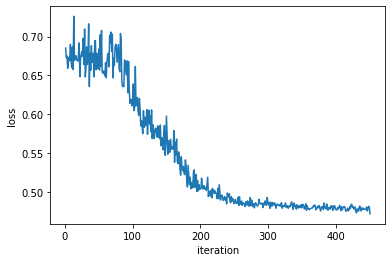

In [25]:
x_plot = np.arange(1,452)
plt.plot(x_plot, vqc_encode_with_num_log)
plt.xlabel('iteration')
plt.ylabel('loss')